# Opening a New Shopping Mall in Trivandrum, India
### IBM Applied Data Science Capstone Course by Coursera
#### Week 5 Final Report


- Build a dataframe of neighborhoods in Trivandrum, India by web scraping the data from Wikipedia page
- Get the geographical coordinates of the neighborhoods
- Obtain the venue data for the neighborhoods from Foursquare API
- Explore and cluster the neighborhoods
- Select the best cluster to open a new shopping mall

## 1. Importing libraries


In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# %conda install -c conda-forge folium # uncomment this folium is not installed
import folium
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pylab as plt
print('Libraries Imported')

Libraries Imported


## 2. Scrap data from Wikipedia to a Data Frame

In [2]:
data = requests.get('https://en.wikipedia.org/wiki/Category:Suburbs_of_Thiruvananthapuram').text
soup = BeautifulSoup(data, 'html.parser')
neighborhood_list = []
for place in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhood_list.append(place.text)
tvm_neighborhood  = pd.DataFrame({"Neighborhood": neighborhood_list})
tvm_neighborhood.sort_values(by =['Neighborhood'], inplace = True)
tvm_neighborhood.head(10)

,Neighborhood
0,Aakkulam
1,"Ambalathara, Thiruvananthapuram"
2,Aryankuzhi
3,Attakulangara
4,Attukal
5,Beemapally
6,"Chala, Thiruvananthapuram"
7,Chengallur
8,Connemara Market
9,East Fort


## 3. Cleaning the Data Frame and adding geographical coordinates

In [3]:
latitude = []
longitude = []
for coord in tvm_neighborhood['Neighborhood']:
    coordinates = Nominatim(user_agent = 'tvm_explorer').geocode('{},Trivandrum'.format(coord))
    if coordinates == None:
        tvm_neighborhood.drop(tvm_neighborhood.loc[tvm_neighborhood['Neighborhood'] == coord].index, inplace = True)
    else:
        latitude.append(coordinates.latitude)
        longitude.append(coordinates.longitude)
tvm_neighborhood["Latitude"] = latitude 
tvm_neighborhood['Longitude'] = longitude
print("Summary \n Number of neighborhoods = {}".format(tvm_neighborhood.shape[0]+1))
tvm_neighborhood.head(10)

Summary 
 Number of neighborhoods = 58


,Neighborhood,Latitude,Longitude
0,Aakkulam,8.516299,76.892079
1,"Ambalathara, Thiruvananthapuram",8.451039,76.949729
3,Attakulangara,8.479351,76.947455
4,Attukal,8.465874,76.966623
5,Beemapally,8.456100,76.934447
6,"Chala, Thiruvananthapuram",8.482888,76.949420
7,Chengallur,8.493971,76.979829
8,Connemara Market,8.502751,76.951210
9,East Fort,8.482810,76.947675
10,Jyothi Nagar,8.526479,76.940834


## 4. Visualising the neighboorhood on map

In [4]:
tvm_loc = Nominatim(user_agent = 'tvm_explorer').geocode('Trivandrum, India') 
map_tvm = folium.Map(location = [tvm_loc.latitude, tvm_loc.longitude], zoom_start = 12) 
num = 1
for lat, lng, hood in zip(tvm_neighborhood['Latitude'], tvm_neighborhood['Longitude'], tvm_neighborhood['Neighborhood']):
    label = hood,
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius = 5,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_tvm)
    num += 1
print('{} locations added!'.format(num))
map_tvm   

58 locations added!


## 5. Defining Foursquare Credentials

In [5]:
CLIENT_ID = '42SUYWC3PZCLNQ4L3FSEUUUHAAETDTJU5LD2ECTDFGXFDWO4' # your Foursquare ID
CLIENT_SECRET = 'HAF0SRYNPFGD2HY0Z5ZJRIFLU5LFZISZDQCTO0V4HY10WNKO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## 6. Exploring the neighborhoods of Trivandrum

In [6]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
# obtaining neaby venues in Trivandrum
tvm_venues = getNearbyVenues(names = tvm_neighborhood['Neighborhood'],latitudes = tvm_neighborhood['Latitude'], longitudes = tvm_neighborhood['Longitude'])

Aakkulam
Ambalathara, Thiruvananthapuram
Attakulangara
Attukal
Beemapally
Chala, Thiruvananthapuram
Chengallur
Connemara Market
East Fort
Jyothi Nagar
Kaithamukku
Kamaleswaram
Kaniyapuram
Kannammoola
Karamana
Kariavattom
Kazhakoottam
Kesavadasapuram
Konchiravila
Kowdiar
Kudappanakunnu
Kuzhivila
Manacaud
Mannanthala
Nalanchira
Nemom
Ooruttambalam
Palayam, Thiruvananthapuram
Palkulangara
Pangappara
Pappanamcode
Paravankunnu
Pattom
Peroorkada
Pettah, Thiruvananthapuram
Peyad
Pongumoodu
Poojappura
Poonthura
Pothencode
Pulayanarkotta
Sasthamangalam
Sreekaryam
Thampanoor
Thirumala, Thiruvananthapuram
Thonnakkal
Thumba
Ulloor
Valiyavila
Vanchiyoor
Vattiyoorkavu
Vazhayila
Vazhuthacaud
Vellayambalam
Vellayani
Vettucaud
Vizhinjam


In [8]:
print(tvm_venues.shape)
print('There are {} uniques categories'.format(len(tvm_venues['Venue Category'].unique())))
tvm_venues.head()

(3407, 7)
There are 92 uniques categories


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aakkulam,8.516299,76.892079,The Dhabha Project,8.539703,76.878585,Indian Restaurant
1,Aakkulam,8.516299,76.892079,Veli Tourist Village,8.509979,76.889980,Arcade
2,Aakkulam,8.516299,76.892079,Shanghumukham Beach,8.479029,76.912421,Beach
3,Aakkulam,8.516299,76.892079,Sulthan's Sulaimani,8.556664,76.876321,Tea Room
4,Aakkulam,8.516299,76.892079,Marginfree Hyper Market,8.529659,76.885833,Department Store


In [9]:
#Numbe of venues returned for each neighbourhood
vn_count = pd.DataFrame(tvm_venues.groupby('Neighborhood').count()['Venue'])
vn_count.rename(columns={'Venue':'No. of Venues'}, inplace = True)
vn_count

,No. of Venues
Neighborhood,
Aakkulam,46
"Ambalathara, Thiruvananthapuram",41
Attakulangara,75
Attukal,67
Beemapally,53
"Chala, Thiruvananthapuram",77
Chengallur,66
Connemara Market,86
East Fort,77


## 7. Analysing each neighborhoods

In [10]:
# one hot encoding
tvm_onehot = pd.get_dummies(tvm_venues[['Venue Category']], prefix="", prefix_sep="")

# neighborhood column back to dataframe
tvm_onehot['Neighborhoods'] = tvm_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = list(tvm_onehot.columns[-1:]) + list(tvm_onehot.columns[:-1])
tvm_onehot = tvm_onehot[fixed_columns]

print(tvm_onehot.shape)
tvm_onehot.head()

(3407, 93)


,Neighborhoods,Accessories Store,Airport,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Beach,Bistro,Boutique,Breakfast Spot,Burger Joint,Bus Station,Café,Chinese Restaurant,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Department Store,Design Studio,Dessert Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Golf Course,Gym,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Jewelry Store,Juice Bar,Kids Store,Lake,Lighthouse,Liquor Store,Lounge,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multiplex,Neighborhood,Optical Shop,Other Great Outdoors,Park,Pizza Place,Planetarium,Plaza,Resort,Restaurant,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Stadium,Student Center,Tea Room,Temple,Tennis Stadium,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Warehouse Store,Zoo
0,Aakkulam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Aakkulam,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Aakkulam,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Aakkulam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Aakkulam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 8. Grouping rows by neighborhood and by taking the frequency of occurrence of each category

In [47]:
tvm_grouped = tvm_onehot.groupby('Neighborhoods').mean().reset_index()
print(tvm_grouped.shape)
tvm_grouped

(57, 93)


,Neighborhoods,Accessories Store,Airport,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Beach,Bistro,Boutique,Breakfast Spot,Burger Joint,Bus Station,Café,Chinese Restaurant,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Department Store,Design Studio,Dessert Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Golf Course,Gym,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Jewelry Store,Juice Bar,Kids Store,Lake,Lighthouse,Liquor Store,Lounge,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multiplex,Neighborhood,Optical Shop,Other Great Outdoors,Park,Pizza Place,Planetarium,Plaza,Resort,Restaurant,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Stadium,Student Center,Tea Room,Temple,Tennis Stadium,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Warehouse Store,Zoo
0,Aakkulam,0.000000,0.000000,0.021739,0.021739,0.000000,0.065217,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.043478,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.021739,0.021739,0.000,0.021739,0.000000,0.000000,0.000000,0.021739,0.000000,0.021739,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.021739,0.021739,0.000000,0.000000,0.086957,0.000000,0.000000,0.043478,0.152174,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.021739,0.000000,0.021739,0.000000,0.000000,0.021739,0.043478,0.000000,0.000000,0.000000,0.065217,0.021739,0.021739,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Ambalathara, Thiruvananthapuram",0.024390,0.024390,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.024390,0.048780,0.000000,0.024390,0.000000,0.024390,0.000000,0.024390,0.000000,0.000000,0.024390,0.000000,0.024390,0.000000,0.048780,0.000,0.000000,0.000000,0.000000,0.000000,0.048780,0.000000,0.000000,0.024390,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073171,0.000000,0.000000,0.000000,0.146341,0.024390,0.000000,0.000000,0.024390,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048780,0.048780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.048780,0.000000,0.000000,0.000000,0.024390,0.000000,0.024390,0.000000,0.024390,0.000000,0.024390,0.000000,0.000000
2,Attakulangara,0.000000,0.013333,0.000000,0.013333,0.013333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026667,0.026667,0.013333,0.000000,0.000000,0.026667,0.000000,0.026667,0.000000,0.013333,0.026667,0.013333,0.000000,0.000000,0.040000,0.000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.013333,0.013333,0.013333,0.013333,0.000000,0.000000,0.026667,0.000000,0.000000,0.013333,0.013333,0.080000,0.000000,0.000000,0.040000,0.093333,0.000000,0.000000,0.000000,0.013333,0.026667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.026667,0.000000,0.000000,0.053333,0.026667,0.000000,0.000000,0.013333,0.013333,0.013333,0.013333,0.000000,0.000000,0.040000,0.013333,0.000000,0.000000,0.026667,0.013333,0.000000,0.000000,0.000000,0.000000,0.013333,0.000000,0.013333,0.000000,0.013333,0.000000,0.000000
3,Attukal,0.014925,0.000000,0.000000,0.029851,0.014925,0.000000,0.000000,0.000000,0.014925,0.000000,0.000000,0.000000,0.044776,0.029851,0.000000,0.014925,0.000000,0.014925,0.000000,0.059701,0.014925,0.014925,0.014925,0.000000,0.014925,0

## 9. Creating Data Frame for Shopping Malls in the Neighbourhood

In [48]:
malls = len(tvm_grouped[tvm_grouped["Shopping Mall"] > 0])
print('Number of Neighborhoods where there is minimum one mall:', malls)
tvm_mall = tvm_grouped[["Neighborhoods","Shopping Mall"]]
tvm_mall

Number of Neighborhoods where there is minimum one mall: 48


,Neighborhoods,Shopping Mall
0,Aakkulam,0.021739
1,"Ambalathara, Thiruvananthapuram",0.048780
2,Attakulangara,0.026667
3,Attukal,0.014925
4,Beemapally,0.037736
5,"Chala, Thiruvananthapuram",0.025974
6,Chengallur,0.030303
7,Connemara Market,0.034884
8,East Fort,0.025974
9,Jyothi Nagar,0.025641


## 10. Clustering Neighborhood 

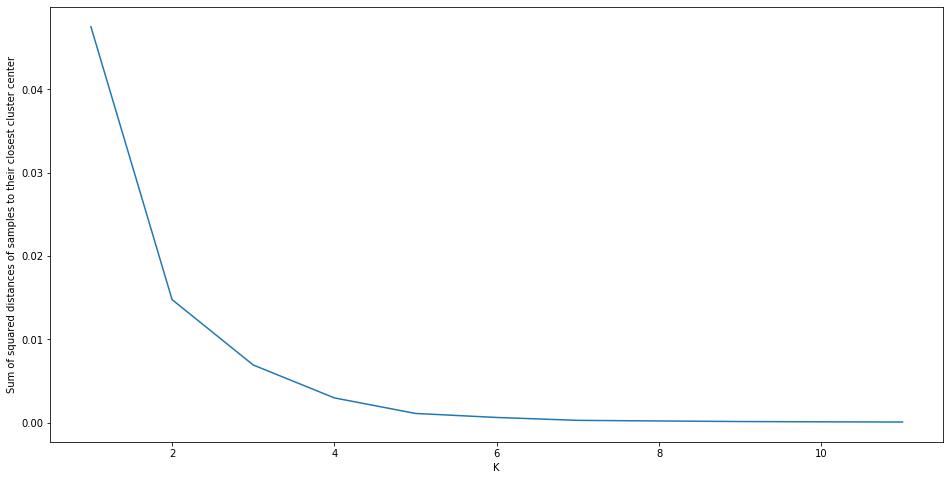

In [13]:
# Choosing the correct value of number of clusters(k) using elbow method
tvm_clustering =  tvm_mall['Shopping Mall'].values.reshape(-1,1) #Taking only the normalised values from tvm_malls
wss = []
k = [x for x in range(1,12)]

for i in k:
    kmeans = KMeans(n_clusters = i).fit(tvm_clustering)
    wss.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(k, wss)
plt.xlabel('K')
plt.ylabel('Sum of squared distances of samples to their closest cluster center')
plt.show()

##### From the plot we can see that the Elbow Point is at k = 4, so we choose the number of cluster to be 4

In [14]:
# Modelling
km = KMeans(n_clusters = 4, random_state = 5)
km.fit(tvm_clustering)
clusters = km.labels_
clusters

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 3,
       0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0,
       2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2])

##### Adding the values of clusters to the Data Frame

In [15]:
tvm_neighborhood['Cluster'] = clusters
print(tvm_neighborhood.shape)
tvm_neighborhood.head(10)

(57, 4)


,Neighborhood,Latitude,Longitude,Cluster
0,Aakkulam,8.516299,76.892079,0
1,"Ambalathara, Thiruvananthapuram",8.451039,76.949729,0
3,Attakulangara,8.479351,76.947455,0
4,Attukal,8.465874,76.966623,2
5,Beemapally,8.456100,76.934447,0
6,"Chala, Thiruvananthapuram",8.482888,76.949420,0
7,Chengallur,8.493971,76.979829,0
8,Connemara Market,8.502751,76.951210,0
9,East Fort,8.482810,76.947675,0
10,Jyothi Nagar,8.526479,76.940834,0


##### Visualising Data

C:\Users\kewin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


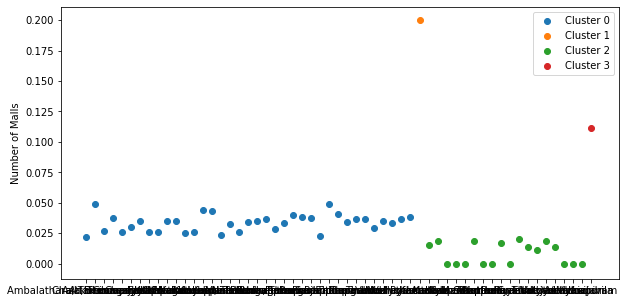

<Figure size 432x288 with 0 Axes>

In [43]:
tvm_mall_new = tvm_grouped[["Neighborhoods","Shopping Mall"]]
tvm_mall_new['Cluster'] = clusters
t1 = tvm_mall_new.loc[tvm_mall_new['Cluster'] == 0]
t2 = tvm_mall_new.loc[tvm_mall_new['Cluster'] == 1]
t3 = tvm_mall_new.loc[tvm_mall_new['Cluster'] == 2]
t4 = tvm_mall_new.loc[tvm_mall_new['Cluster'] == 3]


plt.figure(figsize=(10,5))
plt.scatter(t1['Neighborhoods'], t1['Shopping Mall'], label = 'Cluster 0')
plt.scatter(t2['Neighborhoods'], t2['Shopping Mall'], label = 'Cluster 1')
plt.scatter(t3['Neighborhoods'], t3['Shopping Mall'], label = 'Cluster 2')
plt.scatter(t4['Neighborhoods'], t4['Shopping Mall'], label = 'Cluster 3')
plt.ylabel('Number of Malls')
plt.legend()
plt.show()
plt.savefig('plot.png')

In [44]:
map_clusters = folium.Map(location = [tvm_loc.latitude, tvm_loc.longitude], zoom_start = 10.5)
x = np.arange(4)

ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tvm_neighborhood['Latitude'], tvm_neighborhood['Longitude'], tvm_neighborhood['Neighborhood'], tvm_neighborhood['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
#map_clusters.save('map_clusters.html')      
map_clusters

## 11. Examining Clusters

##### Cluster 0

In [18]:
tvm_neighborhood.loc[tvm_neighborhood['Cluster'] == 0].reset_index(drop=True)

,Neighborhood,Latitude,Longitude,Cluster
0,Aakkulam,8.516299,76.892079,0
1,"Ambalathara, Thiruvananthapuram",8.451039,76.949729,0
2,Attakulangara,8.479351,76.947455,0
3,Beemapally,8.456100,76.934447,0
4,"Chala, Thiruvananthapuram",8.482888,76.949420,0
5,Chengallur,8.493971,76.979829,0
6,Connemara Market,8.502751,76.951210,0
7,East Fort,8.482810,76.947675,0
8,Jyothi Nagar,8.526479,76.940834,0
9,Kaithamukku,8.488970,76.937830,0


#### Cluster 1

In [19]:
tvm_neighborhood.loc[tvm_neighborhood['Cluster'] == 1].reset_index(drop=True)

,Neighborhood,Latitude,Longitude,Cluster
0,Pothencode,8.618423,76.897693,1


##### Cluster 2

In [20]:
tvm_neighborhood.loc[tvm_neighborhood['Cluster'] == 2].reset_index(drop=True)

,Neighborhood,Latitude,Longitude,Cluster
0,Attukal,8.465874,76.966623,2
1,Kamaleswaram,8.467127,76.948242,2
2,Kaniyapuram,8.587665,76.856070,2
3,Kariavattom,8.561482,76.882980,2
4,Kazhakoottam,8.556815,76.872753,2
5,Mannanthala,8.560675,76.943377,2
6,Nemom,8.452167,77.010054,2
7,Ooruttambalam,8.434331,77.051913,2
8,Pappanamcode,8.470212,76.981113,2
9,Peyad,8.513969,77.019523,2


##### Cluster 3

In [21]:
tvm_neighborhood.loc[tvm_neighborhood['Cluster'] == 3].reset_index(drop=True)

,Neighborhood,Latitude,Longitude,Cluster
0,Kuzhivila,8.403151,77.06993,3


## Observations:
Most of the shopping malls are concentrated in the central area of Trivandrum city, with the highest number in cluster 0. On the other hand, cluster 1 and 3 has very low number to totally no shopping mall in the neighborhoods. This represents a great opportunity and high potential areas to open new shopping malls as there is very little to no competition from existing malls. Meanwhile, shopping malls in cluster 0 are likely suffering from intense competition due to oversupply and high concentration of shopping malls. From another perspective, this also shows that the oversupply of shopping malls mostly happened in the central area of the city, with the suburb area still have very few shopping malls. Therefore, this project recommends property developers to capitalize on these findings to open new shopping malls in neighborhoods in cluster 3 and 1 with little to no competition. Property developers with unique selling propositions to stand out from the competition can also open new shopping malls in neighborhoods in cluster 2 with moderate competition. Lastly, property developers are advised to avoid neighborhoods in cluster 2 which already have high concentration of shopping malls and suffering from intense competition.